# Group 9 - COVID 19 Lockdown Effectiveness
_Fiona Shen 46491996, Liam Flannery 45878099, Nicholas Nicholas 46197095, Ranfang Zheng 45965048_

COVID-19 has upended and fundamentally changed every one of our lives for 1 ½ years and counting. With multiple and continued COVID-19 lockdowns occurring in almost all of Australia, we will be investigating the million-dollar questions of when and how should these lockdowns be enforced? And what are the subsequent effects on COVID-19 infections? Some governments may enforce harsh lockdowns to prevent as many COVID-19 infections as possible, but how much strength is necessary? On the other hand, how much freedom should citizens and businesses be given to live and operate, without too many infections to overwhelm health systems?

In this analysis, we will attempt to perform some data analysis to analyse the effectiveness of lockdown measures on COVID-19 cases. Specifically, we will analyse a measure called 'Stringency Index' and its impact on COVID-19 case numbers in Australia. 



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error

# Data Sources
We gathered a number of data sources that would be relevant to the stringency index/cases relationship. As the Stringency index has not been updated for this year yet, our data has unfortunately been confined to between July-December 2020. 
### Stringency Index
The main data source that we will be analysing is referred to as the 'Stringency Index' which measures _"the stringency of a state government’s response to COVID-19, with a score of 100 indicating a maximum level of restrictions"_.
https://www.abs.gov.au/articles/state-economies-and-stringency-covid-19-containment-measures-december-quarter-2020

### Population Data
We will also be using population data of each state, https://www.abs.gov.au/statistics/people/population/national-state-and-territory-population/latest-release#states-and-territories

### Death Data
We have also selected data about the deaths from COVID. (link here)

### Covid Case Data
The second most important data source is the data on COVID-19 case numbers, broken up by state with data on daily cases as well as cumulative cases. https://github.com/M3IT/COVID-19_Data/blob/master/Data/COVID_AU_state.csv

## Putting the Data Together
In order to be able to compare this data together properly, we will have to combine it into a single dataframe. Our data is in different formats, so we will need to do some normalisation before combining it. 

The steps of this normalisation will be contained in a comment for each cell. 

In [2]:
# Load in each data set (stringency level, population data, data on deaths, data on cases)
strinData = pd.read_csv("files/StringencyData.csv")
popData = pd.read_csv("files/StatePopulation.csv")
deathData = pd.read_csv("files/AUDEATHS.csv")
caseData = pd.read_csv("files/COVID_AU_state.csv")


In [3]:
# Normalise stringency data by labelling the columns properly and dropping unecessary data.
strinData.columns = ["DATE", "NSW", "VIC", "QLD", "SA", "WA", "TAS","NT", "ACT"]
strinData = strinData.drop([184, 185])

In [4]:
# Create new data frame (totalData), by creating a metled dataframe of stringency data
# This breaks up the data by day and by state, i.e. having a seperate column for each state and each day, 
# rather than a column for each day with a seperate column for each state
totalData = pd.melt(strinData, id_vars = ["DATE"], var_name = 'STATE')
totalData.head()

,DATE,STATE,value
0,01/07/2020,NSW,43.52
1,02/07/2020,NSW,43.52
2,03/07/2020,NSW,43.52
3,04/07/2020,NSW,43.52
4,05/07/2020,NSW,43.52


In [5]:
# formatting population data by adding appropriate labels, removing unecessary columns and putting the population numbers into a
# better format
popData.columns = ["STATE", "POPULATION", "x", "y"]
popData = popData[["STATE", "POPULATION"]]
popData = popData.drop([8,9,10])
popData["STATE"] = ["NSW", "VIC", "QLD", "SA", "WA", "TAS","NT", "ACT"]
popData["POPULATION"] = popData["POPULATION"] * 1000

In [6]:
# Adding a population column to the totalData, mapping it to the appropriate state column
totalData["POPULATION"] = totalData.STATE.map(popData.set_index("STATE")["POPULATION"])

In [7]:
# we need to properly format the date data from the caseData in order to merge it with the totalData dataframe
# so we will split up the date column into year, month, day and then set the date column in the proper format using those values

# initialising a column for year, month, day, and day of the year (1-365) in the caseData dataframe
caseData["year"] = caseData["date"]
caseData["month"] = caseData["date"]
caseData["day"] = caseData["date"]
caseData["day_of_year"] = caseData["date"]

In [8]:
# setting year, month, day and day of the year based on breaking up the date column
for i in range(0, len(caseData)):
    caseData["year"][i] = caseData["date"].str.split(pat="-")[i][0]
    caseData["month"][i] = caseData["date"].str.split(pat="-")[i][1]
    caseData["day"][i] = caseData["date"].str.split(pat="-")[i][2]
    caseData["day_of_year"][i] = datetime.strptime(caseData["date"][i], '%Y-%m-%d').timetuple().tm_yday

<ipython-input-8-6535f27a3eb5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  caseData["year"][i] = caseData["date"].str.split(pat="-")[i][0]
<ipython-input-8-6535f27a3eb5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  caseData["month"][i] = caseData["date"].str.split(pat="-")[i][1]
<ipython-input-8-6535f27a3eb5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  caseData["day"][i] = caseData["date"].str.split(pat="-")[i][2]
<ipytho

In [9]:
# reset the date column using the day, month and year 
caseData.date = caseData["day"] + "/" + caseData["month"] + "/" + caseData["year"]

In [10]:
# cast the year, month, day, day of year columns to int so we can use them later
caseData["year"] = caseData["year"].astype(int)
caseData["month"] = caseData["month"].astype(int)
caseData["day"] = caseData["day"].astype(int)
caseData["day_of_year"] = caseData["day_of_year"].astype(int)

In [11]:
# setting the caseData to the same range as the totalData (i.e. from July-December 2020)
caseData = caseData.drop(caseData[caseData.month < 7].index)
caseData = caseData.drop(caseData[caseData.year == 2021].index)

In [12]:
# put the caseData and the totalData in the same order, with the same index
caseData = caseData.reset_index()
totalData = totalData.reset_index()
caseData = caseData.sort_values(by = ['state_abbrev', 'index'])
totalData = totalData.sort_values(by = ['STATE', 'index'])
caseData = caseData.reset_index(drop = True)
totalData = totalData.reset_index(drop = True)

In [13]:
# now that the data is in the same order in both dataframes, can just directly bring over the columns from caseData into totalData
totalData["CASES"] = caseData["confirmed"]
totalData["DEATHS"] = caseData["deaths"]
totalData["DAY"] = caseData["day_of_year"]
totalData["MONTH"] = caseData["month"]
totalData["CUM_CASES"] = caseData["confirmed_cum"]

In [14]:
# cleaning up the data and resetting column names
totalData = totalData.drop(columns=["index"])
totalData.columns = ['DATE', 'STATE', 'STRINGENCY_LEVEL', 'POPULATION', 'CASES', 'DEATHS', 'DAY', 'MONTH', 'CUM_CASES']
totalData.head()

,DATE,STATE,STRINGENCY_LEVEL,POPULATION,CASES,DEATHS,DAY,MONTH,CUM_CASES
0,01/07/2020,ACT,37.96,431800.0,0,0,183,7,108
1,02/07/2020,ACT,37.96,431800.0,0,0,184,7,108
2,03/07/2020,ACT,43.52,431800.0,0,0,185,7,108
3,04/07/2020,ACT,43.52,431800.0,0,0,186,7,108
4,05/07/2020,ACT,43.52,431800.0,0,0,187,7,108


# Data Analysis
The idea of this project is to analyse the effect of lockdowns on COVID-19 numbers. The strength of the lockdown is represented through the STRINGENCY_LEVEL column of the totalData dataframe. We will attempt to use a Linear Regression model to predict case numbers from the stringency level. 

We will first do some quick data analysis to get a shape, and idea of the data that we have brought in.

The data consists of a list of dates from July-December of 2020 and has statistics for number of cases, state, stringency level, date, day of the year, population and deaths. 

### General Analysis
We will start out by plotting cases over time, and then comparing stringency level to cases over time. This will give us a good idea of the general relationships in our data, and whether a linear model will be effective at predicting cases. 

In [15]:
sns.set_style("dark")
sns.set_context("notebook")

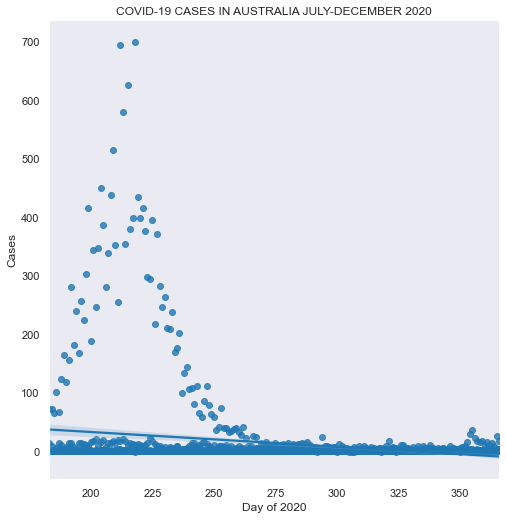

In [16]:
fig = sns.lmplot(data=totalData, x='DAY', y='CASES', height = 7)
fig.set(xlabel = "Day of 2020", ylabel = "Cases", title = "COVID-19 CASES IN AUSTRALIA JULY-DECEMBER 2020")

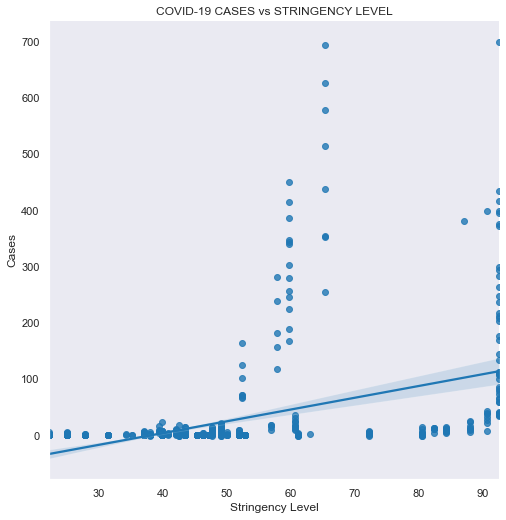

In [17]:
fig = sns.lmplot(data=totalData, x='STRINGENCY_LEVEL', y='CASES', height = 7)
fig.set(xlabel = "Stringency Level", ylabel = "Cases", title = "COVID-19 CASES vs STRINGENCY LEVEL")

From the first graph we can see that there was a spike in cases earlier in the year, which came down quickly later in the year. 
However, both of these graphs have too much data in them to be able to make any more specific observations.

Because of this, we will split the data up into states and store them in an array.
This will allow us to analyse the data more individually.

In [18]:
nsw = totalData[totalData.STATE == "NSW"]
qld = totalData[totalData.STATE == "QLD"]
vic = totalData[totalData.STATE == "VIC"]
act = totalData[totalData.STATE == "ACT"]
nt = totalData[totalData.STATE == "NT"]
wa = totalData[totalData.STATE == "WA"]
sa = totalData[totalData.STATE == "SA"]
tas = totalData[totalData.STATE == "TAS"]
nsw = nsw.reset_index(drop = True)
qld = qld.reset_index(drop = True)
vic = vic.reset_index(drop = True)
act = act.reset_index(drop = True)
nt = nt.reset_index(drop = True)
wa = wa.reset_index(drop = True)
sa = sa.reset_index(drop = True)
tas = tas.reset_index(drop = True)
states = [nsw, qld, vic, act, nt, wa, sa, tas]

Now, using victoria as an example we can get a clearer look at the case numbers and strignency levels. 
Looking at a single state, we are able to gain enough clarity to use Stringency levels as a hue, and get a clear idea of where there were different levels of lockdown and the effect that they had on the case numbers.

[Text(0.5, 0, 'Day'),
 Text(0, 0.5, 'Cases'),
 Text(0.5, 1.0, 'COVID-19 CASES IN VICTORIA JULY-DECEMBER 2020')]

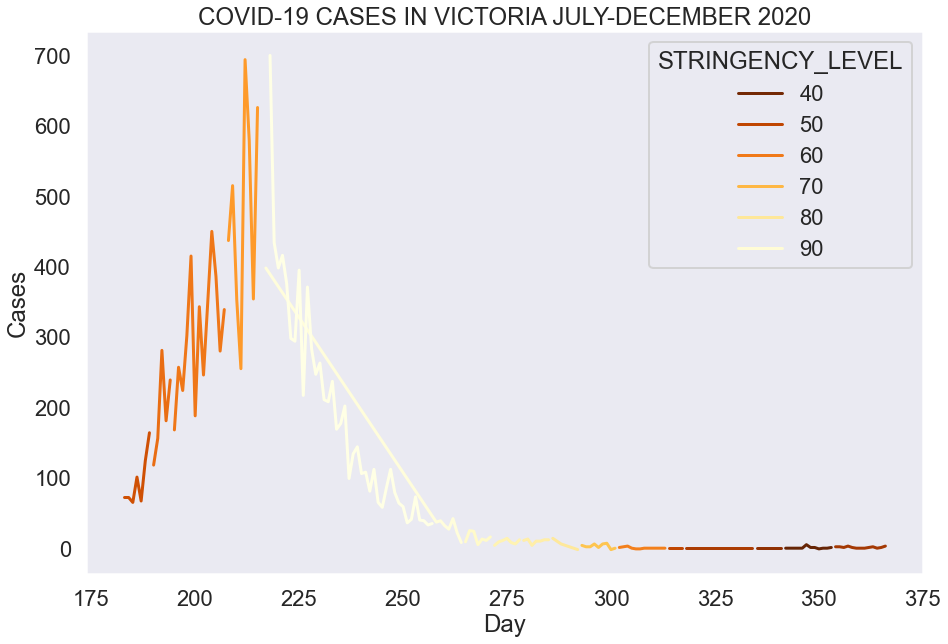

In [19]:
plt.figure(figsize=(15, 10))
sns.set_context("poster")
fig = sns.lineplot(data = vic, x = 'DAY', y = 'CASES', hue = 'STRINGENCY_LEVEL', palette = 'YlOrBr_r')
fig.set(xlabel = "Day", ylabel = "Cases", title = "COVID-19 CASES IN VICTORIA JULY-DECEMBER 2020")

### Analysis Summary
By splitting up the totalData into state by state analysis, we were able to more clearly observe the data and get an idea of the effect that different stringency levels had on the case numbers. 

Looking at Victoria, we can see that the highest strigency level was able to have the most effect on bringing down case numbers.

# Linear Regression Model
As we can see from the graphs above, there is no clear linear relationship between Stringency_Level and daily cases. This likely occurs for two reasons:
1. Stringency level comes up in response to an increased of cases, but cases also come down in response to an increased stringency level
2. The effect of an increased strigency level is longer term, rather than day to day (i.e. an increased stringency level does not take effect immediately)

As a result of this, passing cases and stringency level into a linear regression model will likely not provide accurate results.

In order to account for the longer term nature of the relationship between stringency level and cases, we will run the linear regression model multiple times with different representations of case numbers:
1. Firstly we will run the linear regression model with just the daily cases, this will establish if there is any relationship at all between the daily case number and the daily stringency level.
2. We will then run the model again taking an average of the case numbers over a 7 day bracket (this will smooth out the data and account somewhat for longterm changes.
3. We will then run the model with a 14 day bracket. 

After running the model with these three representations of case numbers, we will compare the accuracy scores to analyse if the relationship between stringency level and case numbers becomes any more linear with a longer term lense. 

In [20]:
totalData["7DCASES"] = totalData["CASES"].rolling(7).sum()
totalData["14DCASES"] = totalData["CASES"].rolling(14).sum()

In [21]:
totalDataLR = totalData.drop(["STATE", "DATE"], axis = 1)

In [49]:
def linearPredict(totalDataLR, x, y):
    totalDataLR = totalDataLR.dropna()
    train, test = train_test_split(totalDataLR, test_size=0.2, random_state=142)
    x_train = train[[x]]
    y_train = train[y]
    x_test = test[[x]]
    y_test = test[y]
    reg = linear_model.LinearRegression()
    reg.fit(x_train, y_train)
    train_preds = reg.predict(x_train)
    print("TRAIN SET EVALUATION")
    print("MSE: ", mean_squared_error(y_train, train_preds))
    print("R Squared: ", r2_score(y_train, train_preds))
    print("\nTEST SET EVALUATION")
    test_preds = reg.predict(x_test)
    print("MSE: ", mean_squared_error(y_test, test_preds))
    print("R Squared: ", r2_score(y_test, test_preds))

In [50]:
print("###Daily Cases###")
linearPredict(totalDataLR, 'STRINGENCY_LEVEL', 'CASES')
print("\n###7 Day Average Cases###")
linearPredict(totalDataLR, 'STRINGENCY_LEVEL', '7DCASES')
print("\n###14 Day Average Cases###")
linearPredict(totalDataLR, 'STRINGENCY_LEVEL', '14DCASES')

###Daily Cases###
TRAIN SET EVALUATION
MSE:  3618.306141358391
R Squared:  0.20730293944079892

TEST SET EVALUATION
MSE:  1574.9513593374356
R Squared:  0.1361681842860354

###7 Day Average Cases###
TRAIN SET EVALUATION
MSE:  150470.4793129541
R Squared:  0.25991453584713897

TEST SET EVALUATION
MSE:  80770.86387722376
R Squared:  0.22044218819091344

###14 Day Average Cases###
TRAIN SET EVALUATION
MSE:  538147.5131875814
R Squared:  0.3043312657144335

TEST SET EVALUATION
MSE:  320595.7348524463
R Squared:  0.3064053702908086


### Analysis of Linear Regression Model
As seen through running the linear regression model, looking at the data in the longer term gives us a much higher mean squared error and a higher r squared value. This means that there is far more variance between the actual and predicted values from the model, but more of this variance is explained by the model. 

Through this analysis we can see that the method that we used did not actually produce a better model. This is likely because the relationship between stringency level and cases is not linear. 

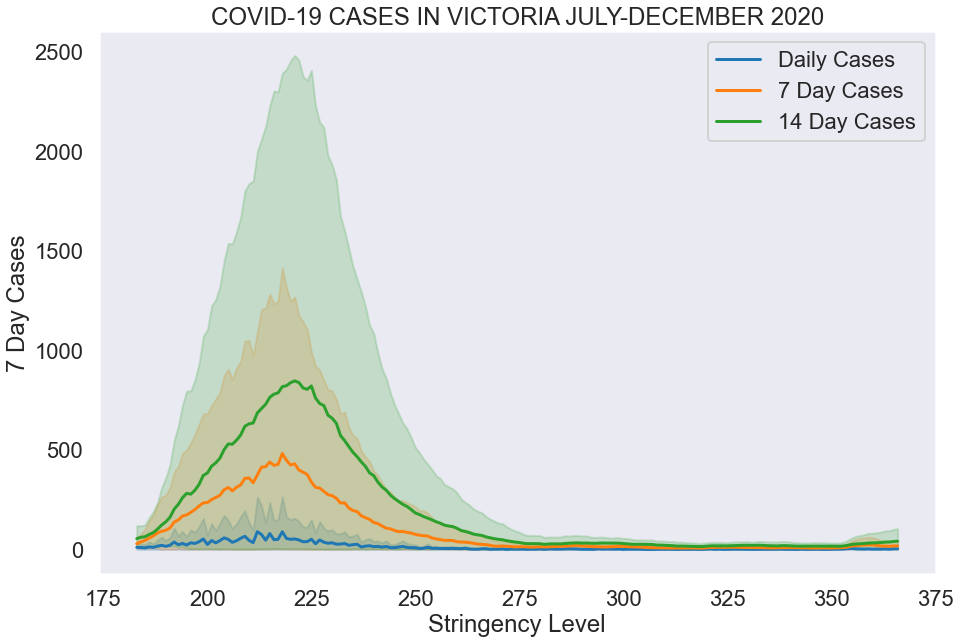

In [48]:
plt.figure(figsize=(15, 10))
sns.set_context("poster")
fig = sns.lineplot(data = totalData, x = 'DAY', y = 'CASES', label = 'Daily Cases')
fig = sns.lineplot(data = totalData, x = 'DAY', y = '7DCASES', label = '7 Day Cases')
fig = sns.lineplot(data = totalData, x = 'DAY', y = '14DCASES', label = '14 Day Cases')
fig.set(xlabel = "Stringency Level", ylabel = "7 Day Cases", title = "COVID-19 CASES IN VICTORIA JULY-DECEMBER 2020")
plt.legend()

# Summary
The purpose of this project was to analyse the effect of the Stringency Level (or lockdown strength) on COVID-19 Case numbers in Australia. As Stringency Level tends to have a longer term effect on case numbers, rather than day to day, we attempted to view the effect of Strignency Level over 1 day, 7 days and 14 days.

Our analysis of the relationship was unsucessful, and our linear regression model could not accurately plot the relationship between Stringency Level and COVID Case numbers. This was likely because the relationship between Stringency Level and case numbers was not linear, and the increase/decrease of cases is also not linear. 

In our analysis we attempted to create a linear relationship between case numbers and stringency level by taking a longer term approach to it, however this was also unsuccessful. 

However, although we were limited by our knowledge of proper data analysis models, it was clear from our data exploration that there is a relationship between stringency levels and case numbers. It was clear in our graphing of cases coloured by stringency level that a higher strignency level did result in case numbers dropping. Whether this was a matter of correlation or causation however, is unclear. 

In the future, a more appropriate model that analyses non linear relationships would be extremely useful and we would be able to achieve a more complete analysis of the relationships in this data.